In [27]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
# from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path
from torchvision.utils import draw_segmentation_masks
from torchvision.utils import draw_bounding_boxes
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from IPython.display import Image

In [38]:
def take_photo(filename='photo.jpg', quality=1):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [29]:
plt.rcParams["savefig.bbox"] = 'tight'
def show(imgs):
  if not isinstance(imgs, list):
      imgs = [imgs]
  fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
  for i, img in enumerate(imgs):
      img = img.detach()
      img = F.to_pil_image(img)
      axs[0, i].imshow(np.asarray(img))
      axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [30]:
weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()
model = maskrcnn_resnet50_fpn(weights=weights, progress=False)
proba_threshold = 0.5
score_threshold = 0.75

<IPython.core.display.Javascript object>

Saved to photo.jpg


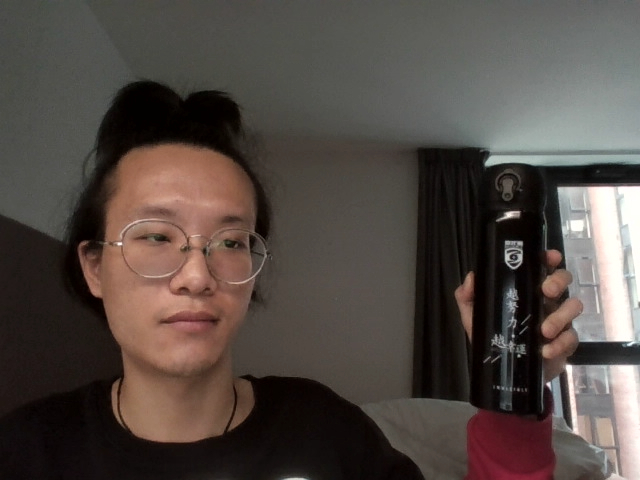

In [39]:
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [40]:
image_int = read_image(str(filename))
images = [transforms(image_int)]
model = model.eval()
output = model(images)

['person', 'cell phone']


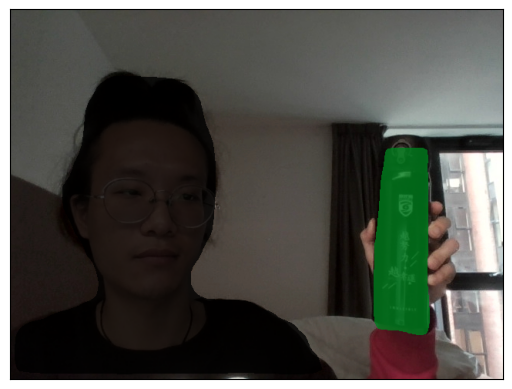

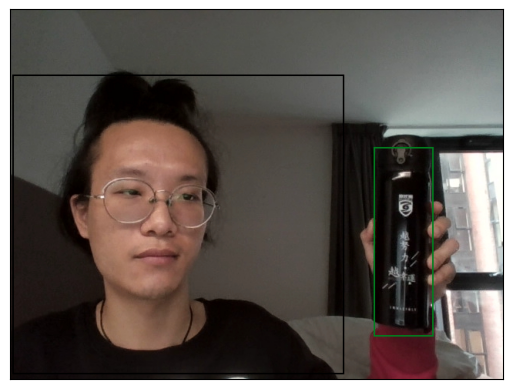

In [41]:
image_output = output[0]
print([weights.meta["categories"][label] for label in image_output['labels'][image_output['scores'] > score_threshold]]) # 打印标签
# 画出图片中的Mask与Boxes
bool_masks = image_output['masks'][image_output['scores'] > score_threshold] > proba_threshold
bool_masks = bool_masks.squeeze(1)
show(draw_segmentation_masks(image_int, bool_masks))
image_boxes = image_output["boxes"][image_output['scores'] > score_threshold]
show(draw_bounding_boxes(image_int, image_boxes, width=2))
# result_list = [mask, boxes]
# grid = make_grid(result_list)
# show(grid)